# CS 4372.501.F22-Assignment 3


## Noah Khan and Ian Lunt

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import random

import time
import matplotlib.pylab as plt
import tensorflow_hub as hub

import datetime

### PREPROCESSING AND ATTRIBUTE ANALYSIS

In [3]:
import pathlib
dataset_url = "https://github.com/IanLunt/datasets/raw/main/pizzadataset.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='pizzadataset')
data_dir = pathlib.Path(data_dir)
unzipped_data_dir = "/root/.keras/datasets/pizzadata"
unzipped_data_dir =  pathlib.Path(unzipped_data_dir)
import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(unzipped_data_dir)

pizza_not_pizza_dir = "/root/.keras/datasets/pizzadata/pizza_not_pizza"
pizza_not_pizza_dir =  pathlib.Path(pizza_not_pizza_dir)

105478742/105478742 [==============================] - 0s 0us/step


In [4]:
# checking to make sure that all of our images are in the right place
image_count = len(list(pizza_not_pizza_dir.glob('*/*.jpg')))
print(image_count)


1966


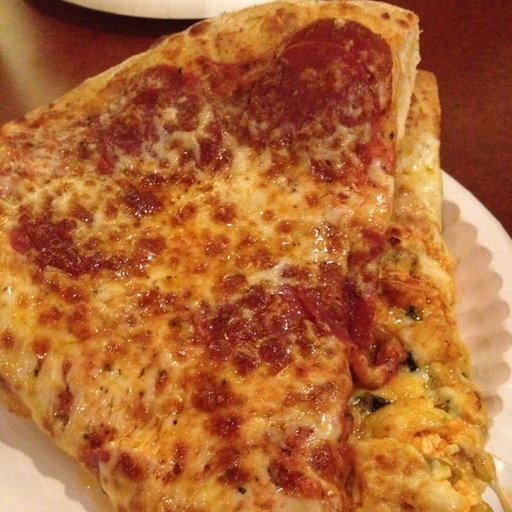

In [5]:
# picture of pizza
pizza = list(pizza_not_pizza_dir.glob('pizza/*'))
PIL.Image.open(str(pizza[random.randint(0,len(pizza))]))


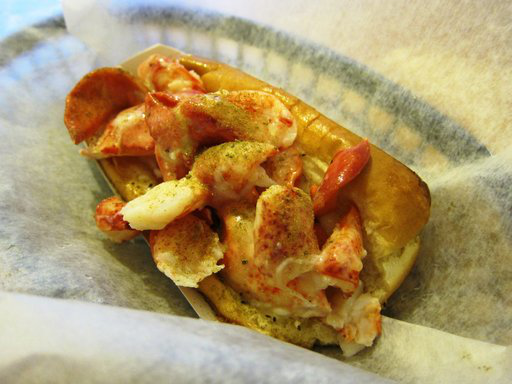

In [6]:
#picture of not pizza
not_pizza = list(pizza_not_pizza_dir.glob('not_pizza/*'))
PIL.Image.open(str(not_pizza[random.randint(0,len(not_pizza))]))

In [184]:
#creating train / validation set 
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(pizza_not_pizza_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(pizza_not_pizza_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 1966 files belonging to 2 classes.
Using 1573 files for training.
Found 1966 files belonging to 2 classes.
Using 393 files for validation.


In [185]:
# making sure our class names are correct
class_names = np.array(train_ds.class_names)
print(class_names)


['not_pizza' 'pizza']


In [182]:
#rescalling our data 
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.


In [179]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [180]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [141]:
#we used mobile net v2 as our pre built model
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [163]:
#creating the layer from the pre built model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)


In [144]:
#creating the actual model
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2)
  
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [187]:
#creating the predictions for the model
predictions = model(image_batch)

In [188]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [148]:
#training the model 
NUM_EPOCHS = 5

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/5
50/50 [==============================] - 9s 102ms/step - loss: 0.2654 - acc: 0.8938 - val_loss: 0.1426 - val_acc: 0.9542
Epoch 2/5
50/50 [==============================] - 4s 74ms/step - loss: 0.1518 - acc: 0.9447 - val_loss: 0.1293 - val_acc: 0.9542
Epoch 3/5
50/50 [==============================] - 4s 81ms/step - loss: 0.1238 - acc: 0.9530 - val_loss: 0.1226 - val_acc: 0.9542
Epoch 4/5
50/50 [==============================] - 4s 75ms/step - loss: 0.1162 - acc: 0.9587 - val_loss: 0.1212 - val_acc: 0.9491
Epoch 5/5
50/50 [==============================] - 4s 75ms/step - loss: 0.1007 - acc: 0.9625 - val_loss: 0.1172 - val_acc: 0.9466


In [149]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 421ms/step
['pizza' 'not_pizza' 'pizza' 'pizza' 'not_pizza' 'not_pizza' 'pizza'
 'pizza' 'not_pizza' 'not_pizza' 'not_pizza' 'not_pizza' 'not_pizza'
 'not_pizza' 'pizza' 'pizza' 'not_pizza' 'not_pizza' 'not_pizza'
 'not_pizza' 'pizza' 'not_pizza' 'not_pizza' 'not_pizza' 'pizza' 'pizza'
 'pizza' 'not_pizza' 'pizza' 'pizza' 'pizza' 'not_pizza']


In [174]:
#transforming the labels from 0 1 to not pizza pizza
labels = []
for n in range(len(labels_batch.numpy())):
  if labels_batch.numpy()[n] == 1:
    labels.append( "pizza")
  else:
    labels.append( "not pizza")

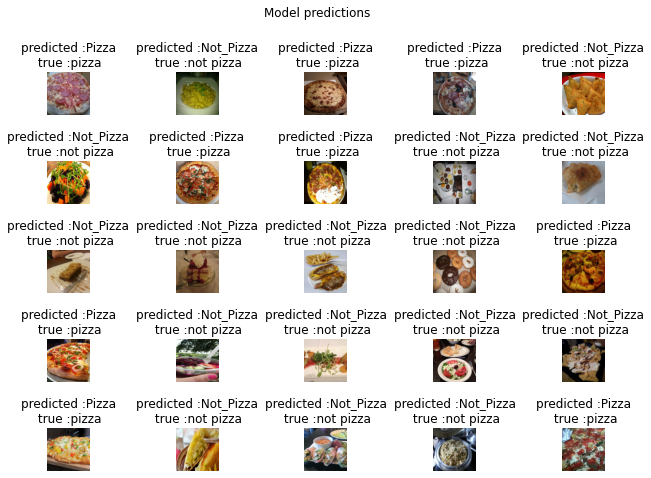

In [175]:
#plotting 25 images and their predicted true values
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=1,wspace = 2)

for n in range(25):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title("predicted :" + predicted_label_batch[n].title() + "\n true :" + labels[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

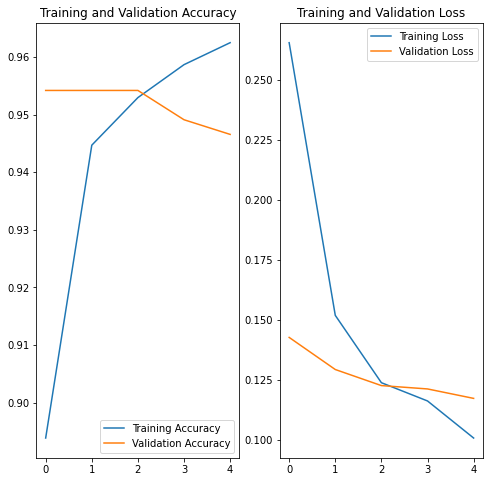

In [172]:
#plotting the accuracy and loss graphsS
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
